In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from rusenttokenize import ru_sent_tokenize
import pymorphy3

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, \
f1_score, log_loss
import evaluate
from scipy.special import softmax

from itertools import chain
from collections import Counter
import re

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification,  \
Trainer, TrainingArguments

import json
import yaml

import tqdm
from tqdm import tqdm_notebook
from tqdm.auto import tqdm

from typing import Dict

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Описание задачи

Определение тональности отзывов клиентов онлайн-магазина "Ozon".

Источник отзывов - otzovik.com

Тональность определялась как позитив/негатив (метки 1/0). Отзывы, которые клиенты оценивали до 3 баллов включительно расценивались как негативные (0), 4,5 баллов - позитивные (1).

В качестве классификатора тональности используется предобученная модель Bert для русского языка rubert-tiny2, дообученная на более чем 11000 отзывах клиентов онлайн магазина "Ozon".



In [3]:
config_path = "../config/config.yaml"
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

In [5]:
preproc = config['preprocessing']
train_params = config['train']

In [6]:
data = pd.read_csv(preproc['raw_path'], encoding='UTF-8')

In [9]:
data

,reviewText,label
0,Впервые я взяла рассрочку(никогда ничего не бр...,1
1,"Только что увидела дешевый флэш накопитель, оп...",3
2,С данным интернет-магазином я познакомился год...,5
3,"Наша жизнь не стоит на месте. Время идет, и вс...",4
4,Интернет-магазин Ozon.ru .Этот интернет магази...,5
...,...,...
14801,"Везут товар хрен знает сколько, только завтрак...",1
14802,Заказывал подушку с доставкой на след. день в ...,1
14803,Неделю назад я совершила покупку на сайте мага...,1
14804,Уже в отчаянии адекватно и правильно решить пр...,1


Описание полей

reviewText - содержание отзывов

label - пользовательская оценка

## Preprocessing

In [10]:
def text_preprocess(s: str) -> str:
    """
    Очистка текста
    """
    preprocessed_text = []
    # удаление пробелов в начале и в конце строки
    s = s.strip()
    # приведение букв в нижный регистр
    s = s.lower()
    # отделение пробелами символов ".", ",", "!", "?"
    s = re.sub(r"([.,!?])", r" \1 ", s)
    # заменить на пробелы все символы, кроме а-я, А-Я, ".", ",", "!", "?"
    s = re.sub(r"[^а-яА-Я.,!?]+", " ", s)
    # убрать дублирующие пробелы
    s = re.sub(r"\s{2,}", " ", s)
    # убрать пробелы в начале и в конце строки
    s = s.strip()
    
    return s

In [11]:
data['reviewText'] = data.reviewText.transform(lambda x: text_preprocess(x))

Преобразование оценок отзывов 1-5 в метки позитивный/негативный (1/0)

In [12]:
data['target'] = data.label.apply(lambda x: 1 if x > 3 else 0)
data = data.drop('label', axis=1)
data.drop_duplicates().reset_index(drop=True)

,reviewText,target
0,впервые я взяла рассрочку никогда ничего не бр...,0
1,"только что увидела дешевый флэш накопитель , о...",0
2,с данным интернет магазином я познакомился год...,1
3,"наша жизнь не стоит на месте . время идет , и ...",1
4,интернет магазин . . этот интернет магазин зна...,1
...,...,...
14787,"везут товар хрен знает сколько , только завтра...",0
14788,заказывал подушку с доставкой на след . день в...,0
14789,неделю назад я совершила покупку на сайте мага...,0
14790,уже в отчаянии адекватно и правильно решить пр...,0


In [13]:
def split_data(data: pd.DataFrame, 
               test_size=0.25, 
               random_state=preproc['random_state']) -> tuple:
    """
    Разделение выборки на трейн/тест
    :param: data: датафрейм
    :param: test_size: размер тестовой выборки
    :param: random_state
    :return: tuple: кортеж датафреймов
    """
    train_data, test_data = train_test_split(data,
                                             stratify=data.target,
                                             test_size=test_size,
                                             random_state=random_state)
    
    return train_data.drop_duplicates().reset_index(drop=True), \
            test_data.drop_duplicates().reset_index(drop=True)
    

def get_dataset(path: str) -> pd.DataFrame:
    """
    Загрузка датасета
    :param: path - путь к файлу
    :return: data: датафрейм
    """

    data = pd.read_csv(path)
     
    return data

In [14]:
train_data, test_data = split_data(data)

In [15]:
train_data

,reviewText,target
0,приветствую всех ! раньше все вещи заказывала ...,0
1,"так уж получилось , что на этом сайте я заказы...",1
2,доброго времени ! с озоном знакома с года . за...,1
3,заказал товар на день рождения отцу . доставит...,0
4,в этом магазине покупаю часто т . к . пункт вы...,0
...,...,...
11095,добрый день ! приложение озон у меня достаточн...,1
11096,"буду немногословен , знаю , как вам будет инте...",0
11097,"добрый вечер , уважаемые дамы и господа ! по к...",0
11098,последнее время изменился и эти изменения в лу...,1


## EDA

In [16]:
def plot_text(ax: plt.Axes):
    """
    Выводит процентные значения на столбчатой диаграмме.
    
    Параметры:
        ax (plt.Axes): Объект Axes, на котором отображается 
        столбчатая диаграмма.
    """
    # Перебираем каждый столбец на диаграмме
    for p in ax.patches:
        # Вычисляем процентное значение высоты столбца
        percentage = '{:.1f}%'.format(p.get_height())
        # Аннотируем столбец с процентным значением
        ax.annotate(
            percentage,  # Текст аннотации
            # Координаты аннотации (по центру столбца)
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # Выравнивание текста
            ha='center',
            va='center',
            # Смещение текста относительно координаты
            xytext=(0, 10),
            # Использование смещения в "точках" (points)
            textcoords='offset points',
            fontsize=10
        )

        
def plot_bars(data: pd.DataFrame, target: str):
    """
    Выводит столбчатую диаграмму для данных DataFrame.
    
    Параметры:
        data: DataFrame с данными для построения столбчатой диаграммы.
    """
    # Вычисляем процентное распределение меток
    norm_target = (data[target]
                  .value_counts(normalize=True)
                  .mul(100)
                  .rename('percent')
                  .reset_index())
          
   
    plt.figure(figsize=(9, 6))
    # Строим столбчатую диаграмму
    ax = sns.barplot(x=target, 
                     y='percent', 
                     data=norm_target, 
                     palette='flare')

    # Добавляем процентные значения к столбцам
    plot_text(ax)
    
        
    # Устанавливаем заголовок графика
    ax.set_title('Оценки пользователей', fontsize=14)
    # Устанавливаем подпись оси x
    ax.set_xlabel('Оценки пользователей', fontsize=12)
    # Устанавливаем подпись оси y
    ax.set_ylabel('Доля в процентах', fontsize=12)

    # Отображаем график
    plt.show()        

    

def generate_wordcloud(text: str):
    """
    Генерирует облако слов на основе входного текста.
    
    Параметры:
        text (str): Текст для создания облака слов.
    """
    
    wordCloud = WordCloud(width = 800, 
                          height = 800, 
                          random_state=preproc['random_state'], 
                          background_color='black', 
                          colormap='Set2').generate(text)

    # Создаем фигуру для облака слов
    plt.figure(figsize=(10, 5))
    # Отображаем облако слов
    plt.imshow(wordCloud)
    # Убираем метки по осям x и y
    plt.xticks([])
    plt.yticks([])
    # Показываем облако слов
    plt.show()

In [17]:
train_data.describe(include=['object'])

,reviewText
count,11100
unique,11100
top,приветствую всех ! раньше все вещи заказывала ...
freq,1


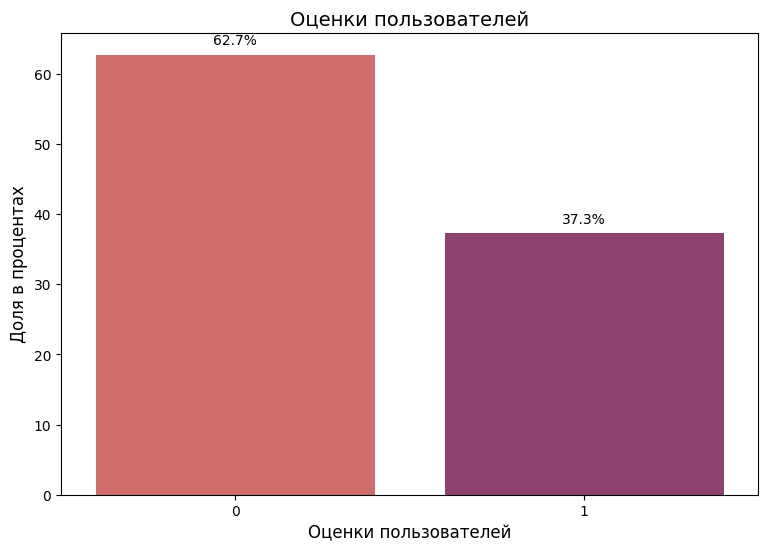

In [18]:
plot_bars(train_data, 'target')

В датасете преобладают негативные отзывы, что в определенной степени говорит о репрезентативности данных, всего на сайте отзовик представлено 23к отзывов со средней оценкой 2.9

In [21]:
def get_data_for_eda(data: pd.DataFrame) -> pd.DataFrame:
    """
    Преобразование исходного датасета в датасет с характеристиками текстов
    для проведения EDA
    :param: data: датафрейм
    :return: data: преобразованный датафрейм
    """
    
    data['Words_count'] = data.reviewText.apply(
        lambda x: len(x.split()))
    
    data['Sentences_count'] =  data.reviewText.apply(
        lambda x: len(ru_sent_tokenize(x)))
    
    data['Review_length'] = data.reviewText.str.len()
    
    data['Mean_word_length'] = data.reviewText.apply(
        lambda x: np.mean([len(t) for t in x.split()]))
    
    data['Mean_sentence_length'] = data.reviewText.apply(
                    lambda rev: np.mean([len(sent) for sent in ru_sent_tokenize(rev)]))
    
    return data

In [22]:
eda_data = train_data.copy()
eda_data = get_data_for_eda(eda_data)

In [30]:
eda_data.head()

,reviewText,target,Words_count,Sentences_count,Review_length,Mean_word_length,Mean_sentence_length
0,приветствую всех ! раньше все вещи заказывала ...,0,552,1,2848,4.161232,2848.000000
1,"так уж получилось , что на этом сайте я заказы...",1,214,2,1129,4.280374,564.000000
2,доброго времени ! с озоном знакома с года . за...,1,161,1,936,4.819876,936.000000
3,заказал товар на день рождения отцу . доставит...,0,88,8,438,3.988636,53.875000
4,в этом магазине покупаю часто т . к . пункт вы...,0,208,13,1080,4.197115,82.153846


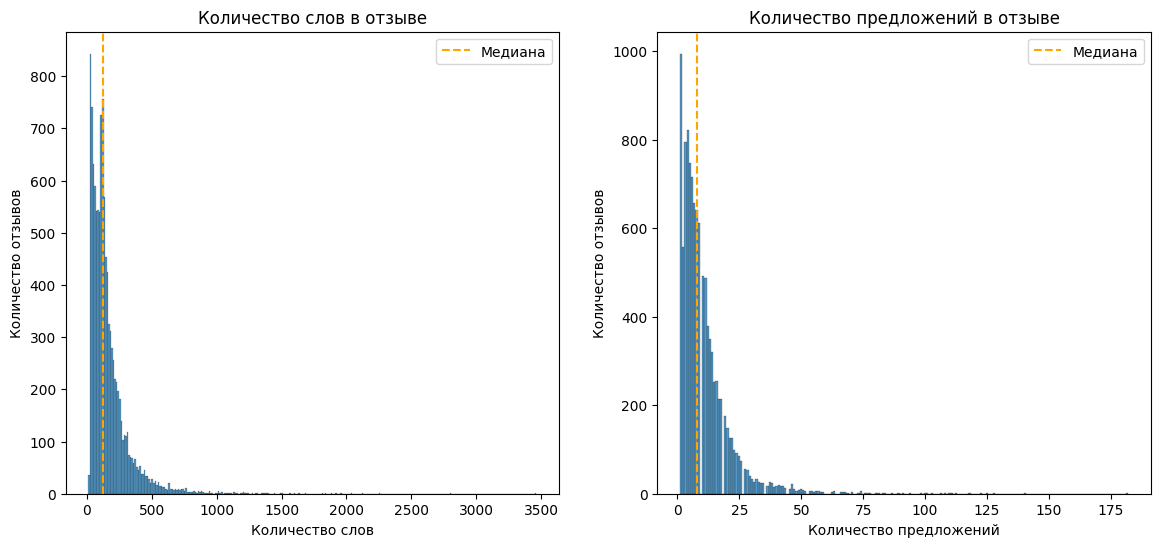

In [53]:
# Гистрограммы распределения количества слов и предложений
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, col in enumerate([eda_data.Words_count, eda_data.Sentences_count]):
    median = col.median()

    sns.histplot(col,
                 ax=axes[i]).set_title(f"Количество {['слов', 'предложений'][i]} в отзыве")

    axes[i].set(xlabel=f"Количество {['слов', 'предложений'][i]}",
                ylabel=f'Количество отзывов')
    axes[i].axvline(median,
                    linestyle='--',
                    color='orange',
                    label='Медиана')
    axes[i].legend()

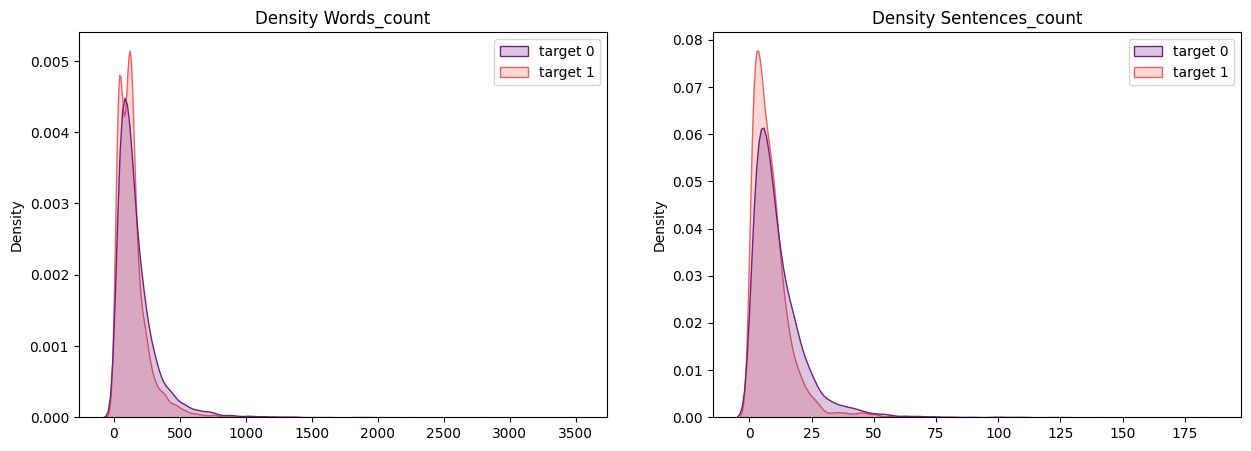

In [37]:
# Плотности распределения количества слов и предложений
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

for i, col in enumerate(['Words_count', 'Sentences_count']):
    sns.kdeplot({'target 0': eda_data[eda_data.target == 0][col],
                 'target 1': eda_data[eda_data.target == 1][col]},
                  common_norm=False,
                  palette='magma',
                  shade=True,
                  ax=axes[i]).set_title('Density '+ col)

Негативные отзывы содержат больше слов и предложений, что кажется логичным: человек, довольный опытом покупки, отзыв либо не оставляет, либо делает это лаконично. Негативные отзывы же содержат больше текста, ввиду того что покупатель старается описать суть проблемы, либо выплескивает эмоции.

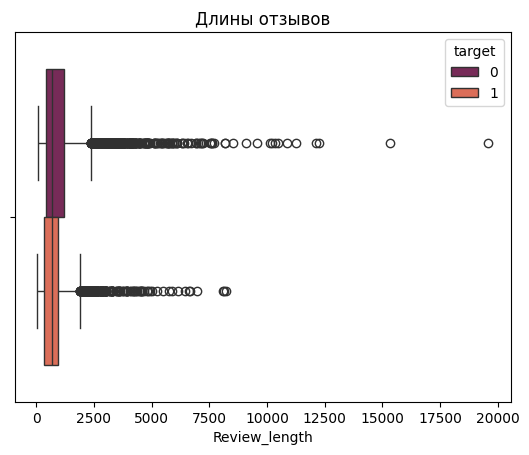

In [42]:
# Построение боксплота длины отзывов
sns.boxplot(data=eda_data, 
            x='Review_length', 
            hue='target',
            palette='rocket')

plt.title('Длины отзывов')
plt.show()

Логично, что и длина негативного отзыва, выраженная количеством символов, больше чем в позитивном.

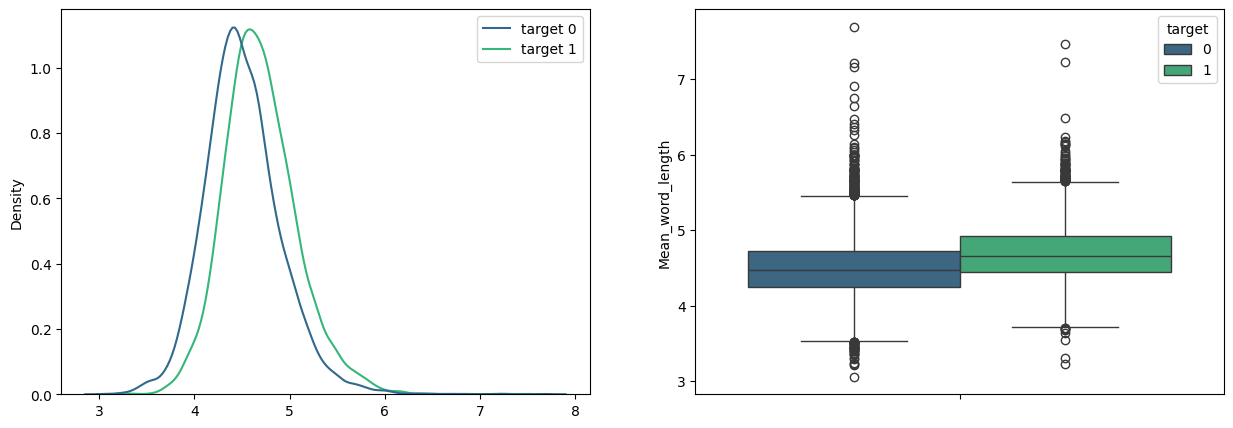

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.kdeplot({'target 0': eda_data[eda_data.target == 0]['Mean_word_length'],
             'target 1': eda_data[eda_data.target == 1]['Mean_word_length']},
              common_norm=False,
              palette='viridis',
              ax=axes[0])

sns.boxplot(data=eda_data, 
            y='Mean_word_length', 
            hue='target', 
            ax=axes[1], 
            palette='viridis')
plt.show()

Средняя длина слова в позитивном отзыве чуть больше чем в негативном.

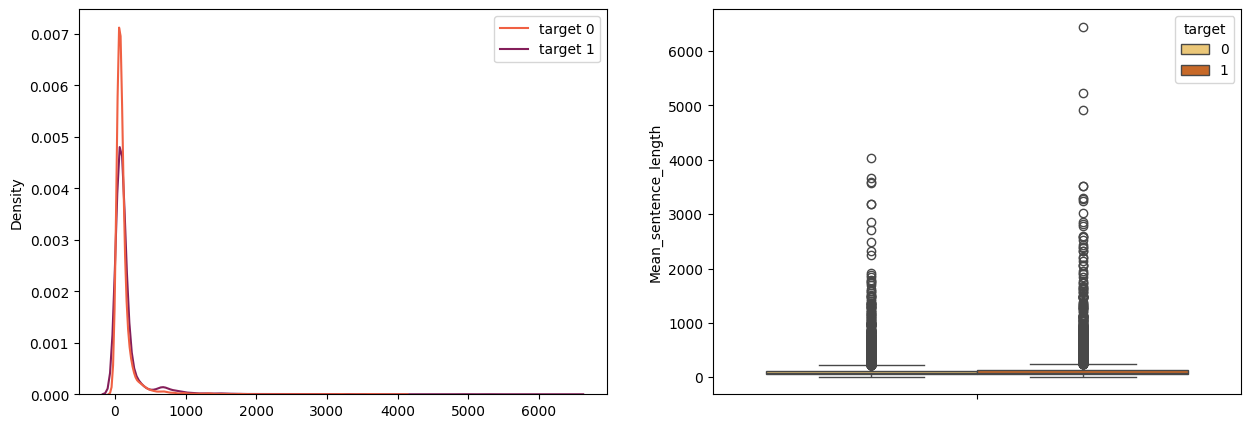

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.kdeplot({'target 0': eda_data[train_data.target == 0]['Mean_sentence_length'],
             'target 1': eda_data[train_data.target == 1]['Mean_sentence_length']},
              common_norm=False,
              palette='rocket_r',
              ax=axes[0])

sns.boxplot(data=eda_data, 
            y='Mean_sentence_length', 
            hue='target', 
            ax=axes[1], 
            palette='YlOrBr')
plt.show()

Визуальной разницы в длинах предложений отзывов, в разрезе целевой переменной, нет.

In [46]:
eda_data.describe()

,target,Words_count,Sentences_count,Review_length,Mean_word_length,Mean_sentence_length
count,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000
mean,0.372883,163.689189,10.659820,903.245045,4.578173,140.084905
std,0.483593,164.783427,10.725244,903.880418,0.405623,251.040093
min,0.000000,9.000000,1.000000,49.000000,3.057143,9.144578
25%,0.000000,67.000000,4.000000,374.000000,4.312612,55.750000
50%,0.000000,122.000000,8.000000,677.000000,4.549644,78.666667
75%,1.000000,200.000000,14.000000,1097.000000,4.812500,124.314286
max,1.000000,3464.000000,182.000000,19585.000000,7.695652,6447.000000


In [50]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', \
                     '...', '«', '»', ';', '–', '--']

stop_words = stopwords.words("russian")

# Корпус всех отзывов (без учета стоп-слов)
corpus = [[word for word in rev.split() if word not in punctuation_marks and word not in  \
          stop_words] for rev in train_data.reviewText.tolist()]

# Словарь корпуса
counter = Counter(chain(*corpus))

# Отсортированные по убыванию пары словаря (слово - количество употреблений в корпусе) 
most = counter.most_common()

words = []
count = []

# 30 самых часто встречаемых слов в словаре
for term in most[:30]:
    words.append(term[0])
    count.append(term[1])

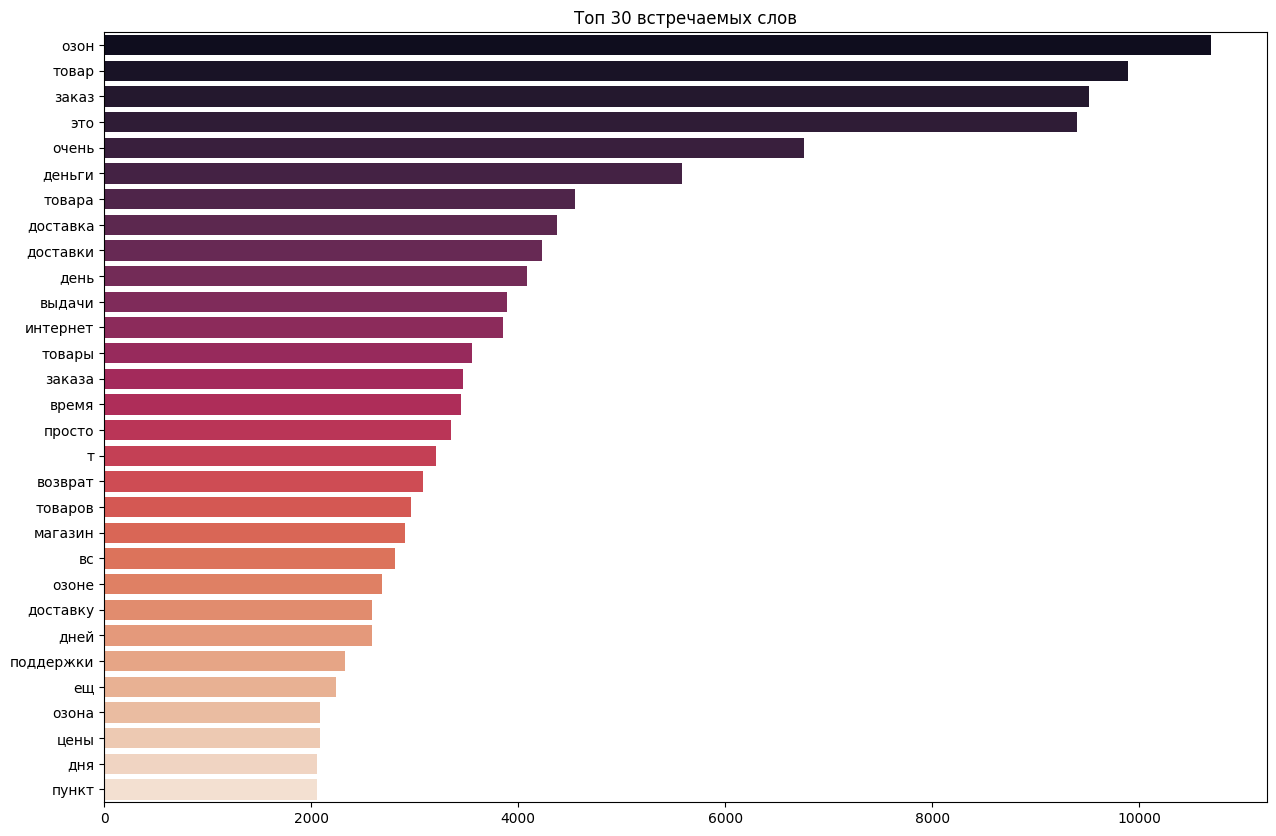

In [51]:
plt.figure(figsize=(15, 10))
sns.barplot(y=words, 
            x=count, 
            orient='h', 
            palette='rocket')

plt.title('Топ 30 встречаемых слов')
plt.show()

В топ-30 попали разные формы слов, касаемых непосредственно процесса покупки товаров, слов. Среди них отсуствуют слова, вносящие сами по себе резко негативный/позитивный оттенок

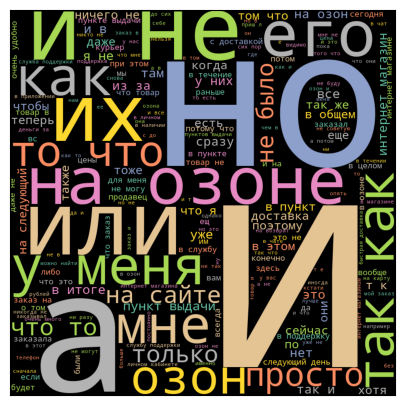

In [49]:
all_tokens = ' '.join(token_string for token_string in train_data.reviewText)
generate_wordcloud(all_tokens)

## Training

In [54]:
train_dataframe = get_dataset(preproc['train_path'])

In [55]:
train_dataframe

,reviewText,target
0,13.11.2020 я осуществила заказ товара на сайте...,0
1,На мой взгляд самый безобразный из интернет ма...,0
2,Пришли по заказу на Озон кроссовки аж из Китая...,0
3,Интернет-магазином пользовалась уже несколько ...,0
4,"Заказ не пришёл вовремя, написал в группу подд...",0
...,...,...
11839,"Очень богатый выбор, активный персонал, покупк...",1
11840,"Буду немногословен, знаю, как вам будет ""интер...",0
11841,"Добрый вечер, уважаемые дамы и господа!По како...",0
11842,"Все конечно удобно, продвинуто, но есть малень...",1


Разделение данных на обучающие/валидационные

In [56]:
train_dataframe, val_dataframe = split_data(train_dataframe, test_size=0.15)

In [58]:
tokenizer = BertTokenizer.from_pretrained(train_params['tokenizer_path'])

In [59]:
class PrepareData:
    """
    Представление текстов с помощью bert-эмбеддингов
    """
    def __init__(self, texts, tokenizer, batch_size_split=10, 
                 max_length=train_params['max_length']):
        
        self.texts = texts
        self.tokenizer = tokenizer
        self.batch_size_split = batch_size_split
        self.max_length = max_length
        
    def pre_tokenizer(self, text):
        return self.tokenizer(text,
                              add_special_tokens=True, 
                              max_length=self.max_length,
                              pad_to_max_length=True,
                              truncation=True,
                              return_attention_mask=True,
                              return_tensors='pt')
    
        
    def transform(self):
        
        N = len(self.texts)
        size_split = N // self.batch_size_split

        train_encodings = self.pre_tokenizer(self.texts[:size_split])
        input_ids = train_encodings['input_ids']
        attention_mask = train_encodings['attention_mask']
        token_type_ids = train_encodings['token_type_ids']

        for pos in tqdm(range(size_split, N, size_split)):
            train_encodings_2 = self.pre_tokenizer(self.texts[pos:pos +
                                                              size_split])
            input_ids = torch.cat((input_ids, train_encodings_2['input_ids']))
            attention_mask = torch.cat(
                (attention_mask, train_encodings_2['attention_mask']))
            token_type_ids = torch.cat(
                (token_type_ids, train_encodings_2['token_type_ids']))
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        } 

In [60]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Класс представления датасета, содержащего объекты-эмбеддинги, поддерживающий
    итерацию для использования с объектом Trainer
    """

    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Если датасет содержит метки класса
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [61]:
clf_train = PrepareData(train_dataframe.reviewText.tolist(), tokenizer)
train_encodings = clf_train.transform()
clf_val = PrepareData(val_dataframe.reviewText.tolist(), tokenizer)
val_encodings = clf_val.transform()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [62]:
train_dataset = CustomDataset(train_encodings, train_dataframe.target.tolist())
val_dataset = CustomDataset(val_encodings, val_dataframe.target.tolist())

In [74]:
model = BertForSequenceClassification.from_pretrained(train_params['model_path'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
def compute_metrics(eval_preds):
    """Расчет метрики roc-auc"""

    metric = evaluate.load("roc_auc")
    logits, labels = eval_preds
    predictions = softmax(logits)[:, 1]
    res = metric.compute(prediction_scores=predictions, 
                         references=labels)

    return {'roc_auc': res['roc_auc']}

In [76]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [77]:
# Заморозка весов и перенос вычислений на GPU
for param in model.bert.parameters():
    param.requires_grad = False

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [78]:
args = TrainingArguments("bert_tiny2",
                         evaluation_strategy="epoch",
                         save_strategy="no",
                         learning_rate=train_params['learning_rate'],
                         num_train_epochs=train_params['epochs'],
                         weight_decay=train_params['weight_decay'],
                         push_to_hub=False,
                         per_device_train_batch_size=train_params['per_device_batch_size'])

In [79]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,No log,0.680252,0.546629
2,No log,0.666451,0.731363
3,No log,0.657462,0.808670
4,0.674800,0.652301,0.834338
5,0.674800,0.650622,0.840691


TrainOutput(global_step=790, training_loss=0.6670907515513746, metrics={'train_runtime': 126.1506, 'train_samples_per_second': 399.007, 'train_steps_per_second': 6.262, 'total_flos': 371180708136960.0, 'train_loss': 0.6670907515513746, 'epoch': 5.0})

In [80]:
def plotting_trainer_loss(trainer: transformers.Trainer) -> None:
    """
    Построение ROC-AUC и Validation Loss
    :param: Trainer
    """
    auc = []
    eval_loss = []
    
    
    for step in trainer.state.log_history:
        try:
            auc.append(step["eval_roc_auc"])
            eval_loss.append(step['eval_loss'])
            
        except KeyError:
            continue
    
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    sns.lineplot(eval_loss, ax=axes[0], color='orange')
    sns.lineplot(auc, ax=axes[1])
    
    axes[0].set_title('Validation Loss')
    axes[1].set_title('ROC-AUC SCORE')
    axes[0].set(xlabel='Epochs')
    axes[1].set(xlabel='Epochs')

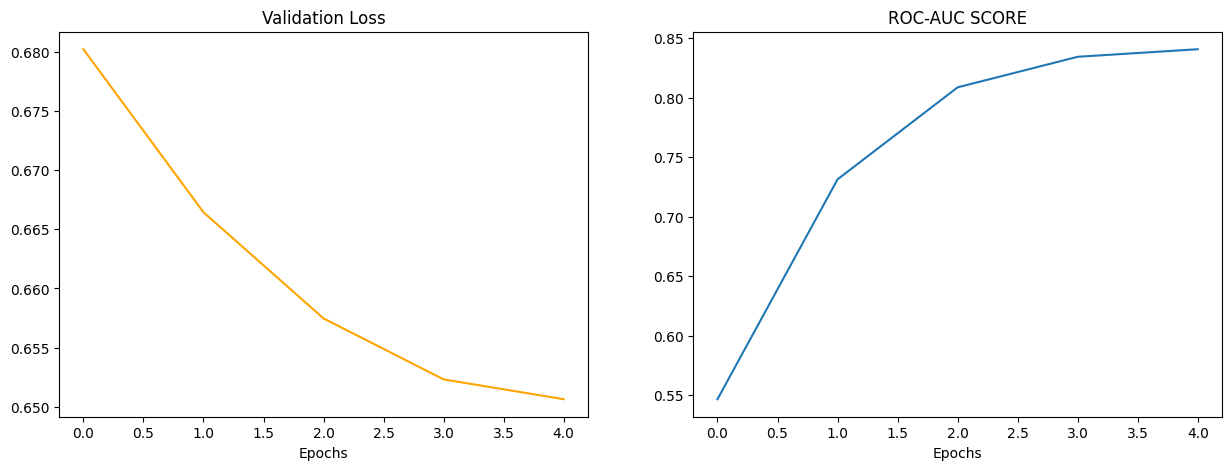

In [81]:
plotting_trainer_loss(trainer)

In [66]:
# Разморозка весов и перенос вычислений на GPU
for param in model.bert.parameters():
    param.requires_grad = True

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [67]:
train_params

{'max_length': 512,
 'random_state': 10,
 'learning_rate': 2e-05,
 'tokenizer_path': 'cointegrated/rubert-tiny2',
 'model_path': 'cointegrated/rubert-tiny2',
 'trainer_path': '../models/history',
 'trainer_log_path': '../models/history/history.json',
 'epochs': 5,
 'weight_decay': 0.01,
 'per_device_batch_size': 64,
 'batch_size_split': 10,
 'metrics_path': '../report/metrics/metrics.json'}

In [68]:
args = TrainingArguments("bert_tiny2",
                         evaluation_strategy="epoch",
                         save_strategy="no",
                         learning_rate=train_params['learning_rate'],
                         num_train_epochs=train_params['epochs'],
                         weight_decay=train_params['weight_decay'],
                         push_to_hub=False,
                         per_device_train_batch_size=train_params['per_device_batch_size'])

In [69]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,No log,0.237884,0.960138
2,No log,0.217142,0.967883
3,No log,0.207418,0.969971
4,0.273900,0.205168,0.970707
5,0.273900,0.205501,0.971189


TrainOutput(global_step=790, training_loss=0.23751381499857843, metrics={'train_runtime': 317.3135, 'train_samples_per_second': 158.629, 'train_steps_per_second': 2.49, 'total_flos': 371180708136960.0, 'train_loss': 0.23751381499857843, 'epoch': 5.0})

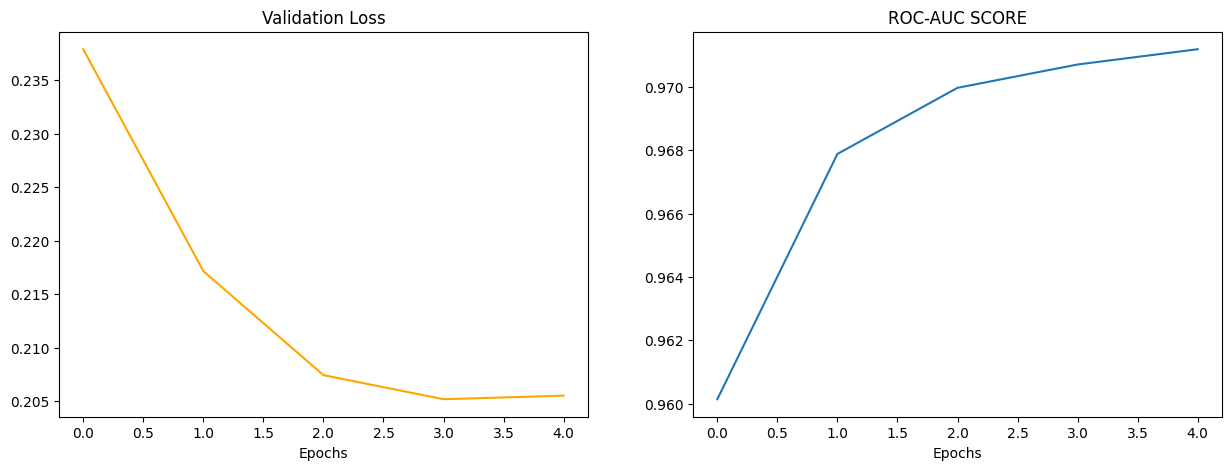

In [72]:
plotting_trainer_loss(trainer)

После разморозки весов модель Bert показывает очень хороший результат на валидационных данных, демонстрируя очень серьезное улучшение ROC-AUC и Validation Loss по сравнению с замороженными параметрами.